In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import re
import operator
import datetime
from collections import Counter
from nltk import ngrams
from utils import *
import gc
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 20,10


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier   
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelPropagation




In [2]:
class Random_Acts_Of_Pizza(object):
    """
    This class takes in a dataframe from "Random Acts Of Pizza"
    and creates a set of features for each requests present in
    the data. The features can be explicitly accessed with the 
    help of methods of this class.
    """
    
    def __init__(self,dataframe):
        """
        The input is a dataframe. We have explicitly used
        data provided from the Kaggle competition named as
        Random Acts Of Pizza.
        Link : https://www.kaggle.com/c/random-acts-of-pizza/data
        """
        self.df = dataframe
    
    def __str__(self):
        return str(self.df.info())
    
    def get_narrative(self, col, narrative):
        """
        Takes input as the column and a lexicon for
        the narrative. The lexicon is in the form of a 
        dictionary where the key is the narrative and the value
        is a string containing all words relating to the
        narrative.
        Outputs a list containing the narrative score for
        each request.
        """
        request_narrative, narration = [], []
        for request in self.df[col]:
            word_count = {'Money': 0, 'Job': 0, 'Student': 0, 'Family': 0, 'Craving': 0}
            for word in request.split():
                for lexicon in narrative:
                    if word in narrative[lexicon]:
                        word_count[lexicon] += 1
            narration.append(max(word_count.items(), key=operator.itemgetter(1))[0])
        print('Use get_dummies to encode the features as binary')
        return narration

    def get_politeness(self,col,polite_words):
        """
        Takes in input as the column for which politeness
        needs to be calculated.
        Output is a list of floats for each request where
        each float corresponds to the politeness score for
        each request.
        """
        count,politeness = 0,[]
        for request in self.df[col]:
            count += 1
            request_ngrams = []
            for grams in ngrams(request.split(),3):
                request_ngrams.append(' '.join(grams))
            for grams in ngrams(request.split(),2):
                request_ngrams.append(' '.join(grams))
            request_words = set(request.split())
            request_ngrams = set(request_ngrams)
            num = len(request_words.intersection(set(polite_words))) +\
            len(request_ngrams.intersection(set(polite_words)))
            try:
                politeness.append(float(num)/len(request_words))
            except:
                politeness.append(0.0)
        print('Total Number of request parsed: ',count)
        return politeness
    
    def get_length(self,col):
        """
        Takes input as the column name(for the request)
        Outputs the length 
        """
        return [len(x.split()) for x in self.df[col]]
    
    def get_karma(self):
        """
        Calculate the karma score for each user of the
        RAOP.
        Output is a list of karma score for each requester.
        """
        karma = self.df['requester_upvotes_plus_downvotes_at_request']+\
        self.df['requester_upvotes_plus_downvotes_at_retrieval']
        return karma
    
    def get_score(self):
        """
        Calculates the score of each user of RAOP.
        Output is a list of score for each user.
        """
        score = self.df['requester_upvotes_minus_downvotes_at_request']+\
        self.df['requester_upvotes_minus_downvotes_at_retrieval']
        return score
    
    def get_evidentiality(self,col):
        """
        We count the occur- rences of http links, image links,
        and “proof”/“prove”
        Returns a list of number of urls for each request.
        """
        urls = []
        for text in self.df[col]:
            url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
            urls.append(len(url))
        return urls
    
    def get_complexity(self,col):
        """
        Takes input as the column of request and calculate
        the complexity score given by Flesch-Kincaid Grade 
        Level.
        Returns a list of complexity score for each request.
        """
        grade_level = []
        syl = set(['a','e','i','o','u'])
        for text in self.df[col]:
            sent_cnt = len(text.split('.'))
            words = re.sub("["+'!"#$%&\'()*+.,-/:;<=>?@[\\]^_`{|}~'+"]", " ", text).split()
            syl_count = 0
            for word in words:
                for letter in list(word):
                    if letter in syl:
                        syl_count += 1
            grade_level.append(Flesch_reading_ease(total_sentences = sent_cnt,total_words = len(words),\
                                                   total_sylabls=syl_count))
        return grade_level
    
    def spell_check_score(self,col):
        """
        We further use a spell-checker to identify misspelled 
        words in the request text [10]. In other contexts 
        (e.g. Kickstarter), spelling errors have been found to
        have a negative impact on funding success.
        
        Input is the column of request.
        Returns a list of spelling check score for each
        request
        """
        spell_errors = []
        for text in self.df[col]:
            spl_err = 0
            words = re.sub("["+'!"#$%&\'()*+.,-/:;<=>?@[\\]^_`{|}~'+"]", " ", text).split()
            if len(words):
                for word in words:
                    if correction(word)!= word: 
                        spl_err += 1
                spell_errors.append(float(spl_err)/len(words))
            else:
                spell_errors.append(0)
        return spell_errors
    
    def first_half_of_month(self,col):
        """
        Input is the column containing the timestamp
        Returns the day of the timestamp for a request
        """
        return [datetime.datetime.fromtimestamp(int(timestamp)).day \
                for timestamp in self.df[col]]
    
    def get_popularity(self,col):
        """
        Input is the column containing the total upvotes
        the request got at time of retrieval
        """
        return self.df[col]
    
    def get_usersimilarity(self , col):
        store = []
        """
        Input:
            column containing username of requesters
        Output:
            score : Their similarity score based on interactions in common
            subreddits between requester and  giver user
        """
        for i in self.df[col]:
            ls = list(self.df[self.df.requester_username == i].requester_subreddits_at_request)
            giver_ = list(self.df[self.df.requester_username == i].giver_username_if_known)
            score = 0
            if len(ls[0]) and giver_[0] != "N/A":
                for j in ls[0]:
                    a = get_post_from_subreddit_by_user(i , j)
                    b = get_post_from_subreddit_by_user(giver_[0] , j)
                    if a != 0 and b != 0:
                        score += (a+b)
            store.append(score)
        return store
    def get_age(self):
        """
        Input : void
        Output : A panda series having the age of account
        (present in dataset already)
        """
        return df['requester_days_since_first_post_on_raop_at_request']
    
    def get_activity(self):
        """
        Input : void
        Output : A panda series having the activity of account
        (present in dataset already)
        """
        return self.df['requester_number_of_subreddits_at_request']
    
    def train_model(self,data,model,response_col,scoring='roc_auc',cv=5):
        """
        Input:
            data : new morphed data frame
            model : the model on which data is to be trained.
            response_col : name of column to be used as
            response
            cv : number of cross validation scores
            scoring : method of scoring
        Output:
            score : k-fold cv score for the model
        """
        data_copy = data.copy()
        y = data_copy.pop(response_col)
        scores = cross_val_score(model,data_copy,y,scoring=scoring,cv=cv)
        del data_copy # Dataframe may be too large
        gc.collect() # Explicitly collecting the garbage
        return scores.mean()

    

In [3]:
df = pd.read_json('./data/train.json')
requests = 'request_text_edit_aware'

In [4]:
raop = Random_Acts_Of_Pizza(df)
print(raop)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 32 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   giver_username_if_known                               4040 non-null   object 
 1   number_of_downvotes_of_request_at_retrieval           4040 non-null   int64  
 2   number_of_upvotes_of_request_at_retrieval             4040 non-null   int64  
 3   post_was_edited                                       4040 non-null   int64  
 4   request_id                                            4040 non-null   object 
 5   request_number_of_comments_at_retrieval               4040 non-null   int64  
 6   request_text                                          4040 non-null   object 
 7   request_text_edit_aware                               4040 non-null   object 
 8   request_title                                         4040

In [5]:
## Calculating all the features
narrative_topics = raop.get_narrative(col=requests,narrative=narrative)
df['narrative_topics'] = narrative_topics
df = pd.get_dummies(df,columns=['narrative_topics'])
df['politeness'] =  raop.get_politeness(col=requests,polite_words=polite_words)
df['request_length'] = raop.get_length(requests)
df['karma'] = raop.get_karma()
df['scores'] = raop.get_score()
df['trust'] = raop.get_evidentiality(requests)
df['complexity'] = raop.get_complexity(requests)
df['popularity'] = raop.get_popularity('number_of_upvotes_of_request_at_retrieval' )
df['age'] = raop.get_age()
df['first_half_of_month'] = pd.Series(raop.first_half_of_month('unix_timestamp_of_request')) < 15
df['activity'] = raop.get_activity()

Use get_dummies to encode the features as binary
Total Number of request parsed:  4040


In [6]:
if not os.path.isfile('data/data_utils/spellCheck.csv'):
    df['spell_check_score'] = raop.spell_check_score(requests)
    df['spell_check_score'].to_csv('spellCheck.csv')
    print(df.spell_check_score.head(2))
else:
    print('File exists...')
    df['spell_check'] = pd.read_csv('data/data_utils/spellCheck.csv',index_col=0,header=None)

File exists...


In [7]:
# Sanity Check
for fname in ['similarity.csv','sentiment.csv','indegree.csv','outdegree.csv','shapley.csv']:
    fname = './data/data_utils/'+fname
    if not os.path.isfile(fname):
        print("{} file doesn't exists...")
        raise
print('All files exists..')

All files exists..


In [8]:
df['similarity'] = pd.read_csv('data/data_utils/similarity.csv',index_col=0,header=None)
df['sentiment'] = pd.read_csv('data/data_utils/sentiment.csv',index_col=0,header=None).iloc[:4040,-1].fillna(0)
df['giver'] = df['giver_username_if_known'].map({'N/A':0}).fillna(1)
df = df.merge(pd.read_csv('data/data_utils/indegree.csv',names=['requester_username','indegree'],header=None))
df = df.merge(pd.read_csv('data/data_utils/shapley.csv',names=['requester_username','shapley'],header=None))
df = df.merge(pd.read_csv('data/data_utils/outdegree.csv',names=['requester_username','outdegree'],header=None))

In [9]:
req_features = [
 'complexity',
 'first_half_of_month',
 'karma',
 'narrative_topics_Craving',
 'narrative_topics_Family',
 'narrative_topics_Job',
 'narrative_topics_Money',
 'narrative_topics_Student',
 'politeness',
 'popularity',
 'request_length',
 'scores',
 'trust',
 'requester_received_pizza',
 'similarity',
 'sentiment',
 'giver',
 'activity',
 'age',
 'indegree',
 'outdegree',
 'shapley'
]


In [10]:
df_new = df.drop([col for col in df.columns if col not in req_features],axis=1)
df_new.head(2)

,requester_received_pizza,narrative_topics_Craving,narrative_topics_Family,narrative_topics_Job,narrative_topics_Money,narrative_topics_Student,politeness,request_length,karma,scores,...,popularity,age,first_half_of_month,activity,similarity,sentiment,giver,indegree,shapley,outdegree
0,False,False,True,False,False,False,0.0,67,1,1,...,1,0.0,True,0,0,2.250,0.0,0,0.0,0
1,False,False,False,False,True,False,0.0,16,11284,4292,...,5,0.0,False,12,0,0.375,0.0,0,0.0,0


In [11]:

model = LogisticRegression(penalty='l2')
auc_score = raop.train_model(df_new,model=model,response_col='requester_received_pizza',cv=2)
acc_score = raop.train_model(df_new,model=model,response_col='requester_received_pizza',cv=2,scoring='accuracy')

In [12]:
print('ROC Score: {}'.format(auc_score*100))
print('Accuracy Score: {}'.format(acc_score*100))

ROC Score: 60.18851123814456
Accuracy Score: 79.38118811881189


### COMPARISON MODELS 

In [13]:


classifiers=[
    (LogisticRegression(penalty='l2'),"LR"),
    (KNeighborsClassifier(5),"KNC"),
    (SVC(),'SVC'),
    (QuadraticDiscriminantAnalysis(),'QDA'),
    (RandomForestClassifier(max_depth=50, n_estimators=10, max_features=1),'RFC'),
    (AdaBoostClassifier(),'ADC'),
    (SGDClassifier(),'SGDC'),
    (DecisionTreeClassifier(max_depth=5),'DTC'),
    (xgboost.XGBClassifier(learning_rate=0.1),'XGB'),
    (LinearDiscriminantAnalysis(),'LDA'),
    (GaussianNB(),'GNB'),
]

In [14]:
score_ , names = [] , []
for model,name in classifiers:
    score = raop.train_model(df_new,model=model,response_col='requester_received_pizza')
    score_.append(score)
    names.append(name)
    print('ROC Score: {}'.format(score*100) , name)

ROC Score: 59.745235402350815 LR
ROC Score: 57.252540781870586 KNC
ROC Score: 59.93118550907496 SVC
ROC Score: 65.82767286543942 QDA
ROC Score: 77.73190183512429 RFC
ROC Score: 81.72148423092234 ADC
ROC Score: 53.59800034910182 SGDC
ROC Score: 80.97684011602956 DTC
ROC Score: 81.51956848152922 XGB
ROC Score: 80.36679832854317 LDA
ROC Score: 74.74037955212057 GNB


In [15]:
from sklearn.model_selection import train_test_split
X = df_new.copy()
y = X.pop('requester_received_pizza')
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=7,test_size=0.1)
model = LabelPropagation(kernel='knn')
model.fit(X_train,y_train)
score_.append(roc_auc_score(y_test,model.predict(X_test)))
names.append('LPC')

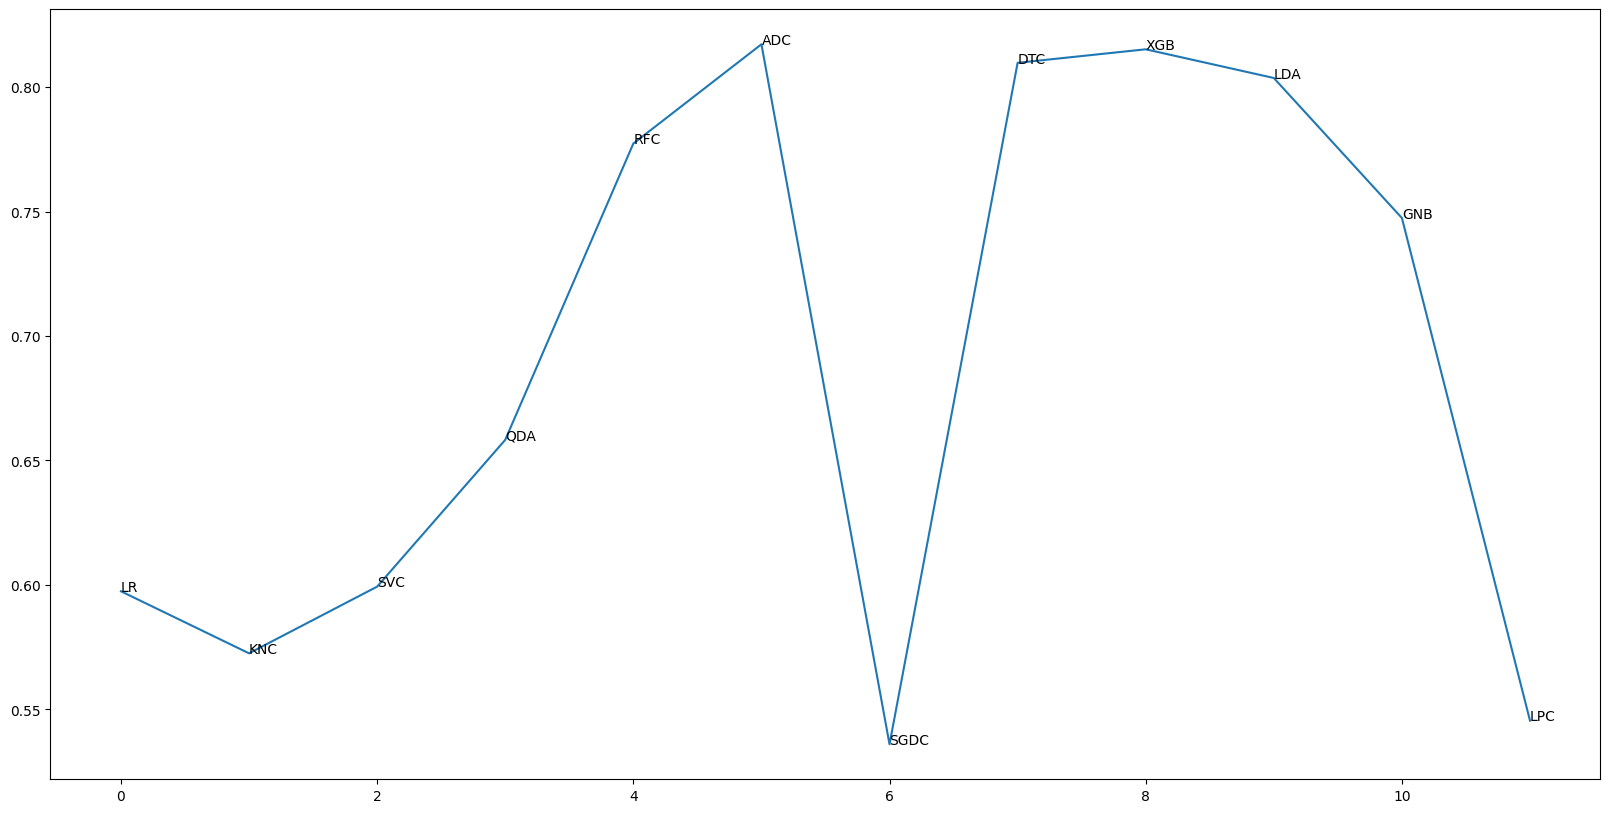

In [16]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
A = score_[:]
plt.plot(A)
for i, label in enumerate(names):
    plt.text(i,A[i], label) 
plt.show()